In [28]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm

import sys
sys.path.append('../functions')
import hexbin_functions as hexfunc

import flock_measures as flock

# Spatial Variations

In [51]:
location = 'Cape_Hatteras'
member = 6
std = 0.1

file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/{location}/spatial/dr_{std*100:03.0f}/{location}_dr{std*100:03.0f}_m{member:03d}.zarr"
pset = xr.open_zarr(file_path)

In [52]:
lons = pset['lon'][:, :].values
lats = pset['lat'][:, :].values

CM_lons, CM_lats = flock.center_of_mass_displacement(pset['lon'], pset['lat'])
CM_lons += np.mean(lons[:,0])
CM_lats += np.mean(lats[:,0])

sigma_lons, sigma_lats = flock.center_of_mass_spread(lons, lats)

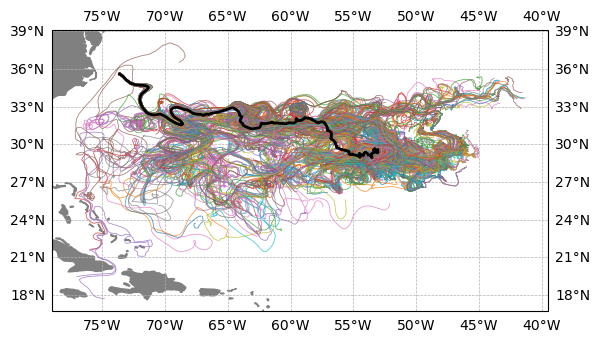

In [53]:
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.set_extent([-78, -70, 33, 40], crs=cartopy.crs.PlateCarree())
# ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, color='gray')
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

for i in range(1000):
    ax.plot(lons[i,:], lats[i,:], lw=0.5, alpha=0.5);

ax.plot(CM_lons, CM_lats, 'k', lw=2)

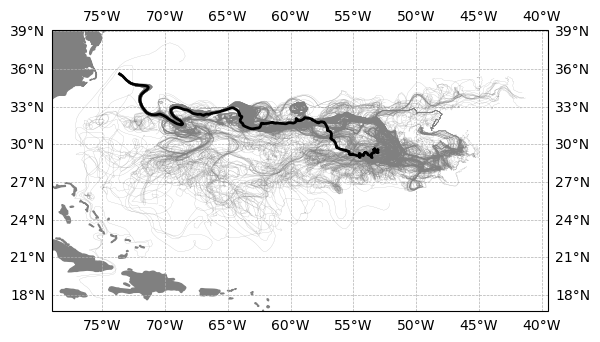

In [55]:
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.set_extent([-78, -70, 33, 40], crs=cartopy.crs.PlateCarree())
# ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=0, color='gray')
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)


ax.plot(lons[:,:].T, lats[:,:].T, lw=0.1, alpha=0.5, color='gray');

ax.plot(CM_lons, CM_lats, 'k', lw=2)

In [43]:
D, D_mean, D_std = flock.relative_dispersion(lons, lats, CM_lons, CM_lats)

Text(0, 0.5, 'Mean Displacement from Center of Mass [km]')

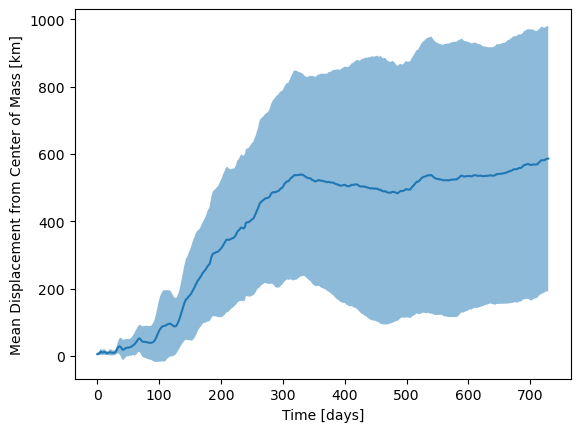

In [44]:
plt.plot(D_mean/1000)
plt.fill_between(np.arange(len(D_mean)), (D_mean-D_std)/1000, (D_mean+D_std)/1000, alpha=0.5)
plt.xlabel('Time [days]')
plt.ylabel('Mean Displacement from Center of Mass [km]')


In [76]:
delta_r_ranges = np.linspace(0.1, 1, 10)

location = 'Cape_Hatteras'
N_members = 50
N_obs = len(pset.obs)
D_means = np.zeros((N_members, len(delta_r_ranges), N_obs))
D_stds = np.zeros_like(D_means)
CM_lons = np.zeros_like(D_means)
CM_lats = np.zeros_like(D_means)
delta_r = 0.1

for member in tqdm(range(1, N_members+1)):
    
    for k, delta_r in enumerate(delta_r_ranges):

        file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/{location}/spatial/dr_{delta_r*100:03.0f}/{location}_dr{delta_r*100:03.0f}_m{member:03d}.zarr"
        pset = xr.open_zarr(file_path)
        
        lons = pset['lon'][:, :].values
        lats = pset['lat'][:, :].values
        
        CM_x, CM_y = flock.center_of_mass_displacement(lons, lats)
        CM_x += np.mean(lons[:, 0])
        CM_y += np.mean(lats[:, 0])
        
        CM_lons[member-1, k, :] = CM_x
        CM_lats[member-1, k, :] = CM_y
        
        _, _D_mean, _D_std = flock.relative_dispersion(lons, lats, CM_x, CM_y)
        
        D_means[member-1, k, :] = _D_mean
        D_stds[member-1, k, :] = _D_std
    
D_means = D_means/1000
D_stds = D_stds/1000

100%|██████████| 50/50 [22:46<00:00, 27.33s/it]


In [82]:
xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/Cape_Hatteras/all/Cape_Hatteras_dr010_all_1000.zarr')

/tmp/ipykernel_336155/4188273597.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  xr.open_zarr('/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/Cape_Hatteras/all/Cape_Hatteras_dr010_all_1000.zarr')


<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        EnsembleParticleAdvectionRK4_3DSampleFieldKeepInO...
    parcels_mesh:           spherical
    parcels_version:        3.0.2

In [81]:
# can you save the data to a file?
np.save(f'../data/{location}_D_means.npy', D_means)
np.save(f'../data/{location}_D_stds.npy', D_stds)
np.save(f'../data/{location}_CM_lons.npy', CM_lons)
np.save(f'../data/{location}_CM_lats.npy', CM_lats)

50it [00:50,  1.01s/it]


Text(0.5, 1.0, 'Cape Hatteras $\\delta r = 0.1$')

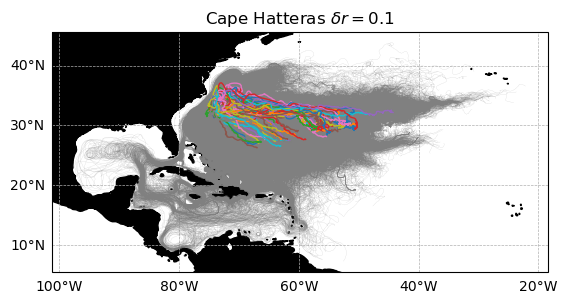

In [72]:
location = 'Cape_Hatteras'
delta_r = 0.1
N_members = 50

fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.set_extent([-85, -10, 13, 40], crs=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=0, color='black')
# ax.coastlines()
gl = ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

gl.top_labels = False
gl.right_labels = False

for i, member in tqdm(enumerate(range(1,N_members+1))):

    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/{location}/spatial/dr_{delta_r*100:03.0f}/{location}_dr{delta_r*100:03.0f}_m{member:03d}.zarr"
    pset = xr.open_zarr(file_path)

    lons = pset['lon'][:, :].values
    lats = pset['lat'][:, :].values
    ax.plot(lons[:,:].T, lats[:,:].T, lw=0.1, alpha=0.3, color='gray');

    ax.plot(CM_lons[i,:], CM_lats[i,:], lw=1, zorder=3)
    
plt.title(f"Cape Hatteras $\\delta r = {delta_r}$")


Text(0.5, 1.0, 'Relative Dispersion $\\delta r = 0.1$')

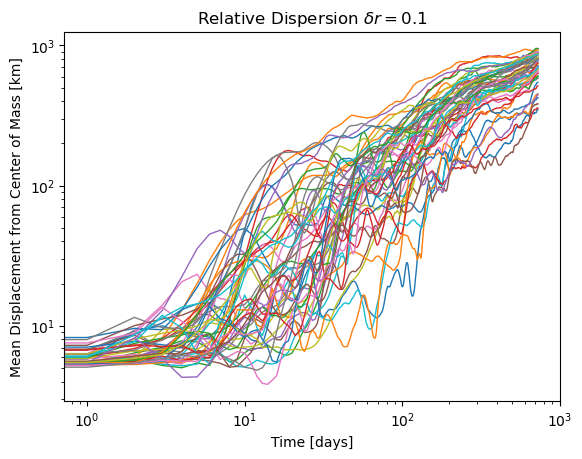

In [ ]:
for i in range(N_members):
    plt.loglog(D_means[i,:], lw=1)

    # plt.fill_between(np.arange(N_obs), D_means[i,:]-D_stds[i,:], D_means[i,:]+D_stds[i,:], alpha=0.1)
    
plt.xlabel('Time [days]')
plt.ylabel('Mean Displacement from Center of Mass [km]')
plt.title(f"Relative Dispersion $\\delta r = {delta_r}$")

Text(0.5, 1.0, 'Center of Mass Displacement Spread $\\delta r = 0.1$')

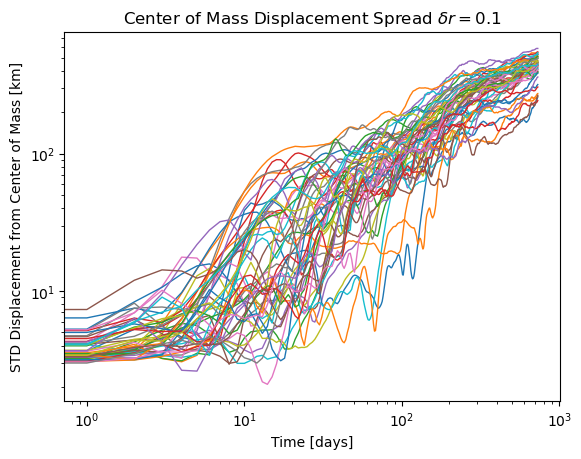

In [ ]:
for i in range(N_members):
    plt.loglog(D_stds[i,:], lw=1)

    # plt.fill_between(np.arange(N_obs), D_means[i,:]-D_stds[i,:], D_means[i,:]+D_stds[i,:], alpha=0.1)
    
plt.xlabel('Time [days]')
plt.ylabel('STD Displacement from Center of Mass [km]')
plt.title(f"Center of Mass Displacement Spread $\\delta r = {delta_r}$")

In [ ]:
location = 'Cape_Hatteras'
N_members = 7
N_obs = len(pset.obs)
D_means = np.zeros((N_members, N_obs))
D_stds = np.zeros_like(D_means)
CM_lons = np.zeros_like(D_means)
CM_lats = np.zeros_like(D_means)
delta_r = 1.

for member in range(1,N_members+1):
    print(f"Member {member}")

    file_path = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/{location}/spatial/dr_{delta_r*100:03.0f}/{location}_dr{delta_r*100:03.0f}_m{member:03d}.zarr"
    pset = xr.open_zarr(file_path)
    
    lons = pset['lon'][:, :].values
    lats = pset['lat'][:, :].values
    
    CM_x, CM_y = flock.center_of_mass_displacement(lons, lats)
    CM_x += np.mean(lons[:, 0])
    CM_y += np.mean(lats[:, 0])
    
    CM_lons[member-1,:] = CM_x
    CM_lats[member-1,:] = CM_y
    
    _, _D_mean, _D_std = flock.relative_dispersion(lons, lats, CM_x, CM_y)
    
    D_means[member-1,:] = _D_mean
    D_stds[member-1,:] = _D_std
    
D_means = D_means/1000
D_stds = D_stds/1000

Member 1
Member 2
Member 3
Member 4
Member 5
Member 6
Member 7


Text(0.5, 1.0, 'Center of Mass Displacement $\\delta r = 1.0$')

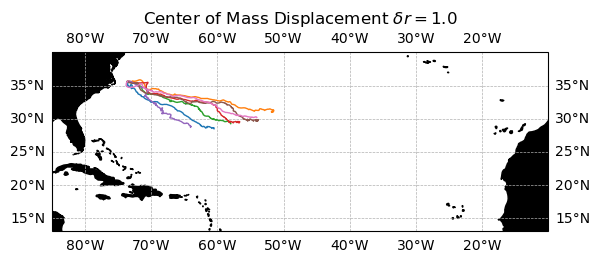

In [117]:
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-85, -10, 13, 40], crs=cartopy.crs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=0, color='black')
# ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

for i in range(7):
    ax.plot(CM_lons[i,:], CM_lats[i,:], lw=1)
    
plt.title(f"Center of Mass Displacement $\\delta r = {delta_r}$")


Text(0.5, 1.0, 'Mean Displacement from Center of Mass $\\delta r = 1.0$')

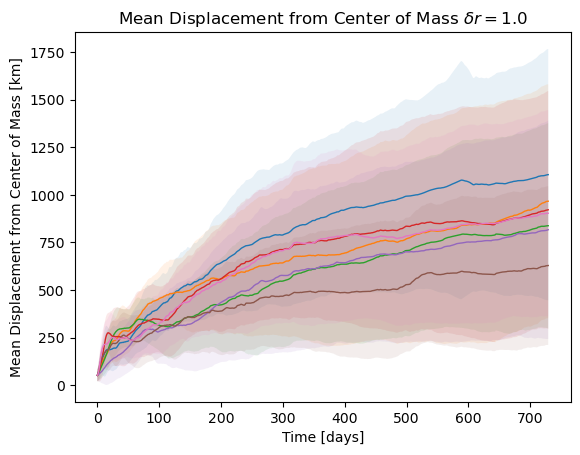

In [120]:
for i in range(7):
    plt.plot(D_means[i,:], lw=1)

    plt.fill_between(np.arange(N_obs), D_means[i,:]-D_stds[i,:], D_means[i,:]+D_stds[i,:], alpha=0.1)
    
plt.xlabel('Time [days]')
plt.ylabel('Mean Displacement from Center of Mass [km]')
plt.title(f"Mean Displacement from Center of Mass $\\delta r = {delta_r}$")

Text(0.5, 1.0, 'STD Displacement from Center of Mass $\\delta r = 1.0$')

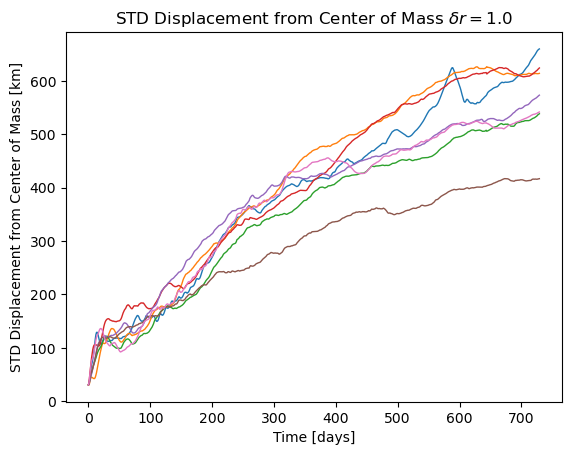

In [121]:

for i in range(7):
    plt.plot(D_stds[i,:], lw=1)

    # plt.fill_between(np.arange(N_obs), D_means[i,:]-D_stds[i,:], D_means[i,:]+D_stds[i,:], alpha=0.1)
    
plt.xlabel('Time [days]')
plt.ylabel('STD Displacement from Center of Mass [km]')
plt.title(f"STD Displacement from Center of Mass $\\delta r = {delta_r}$")